In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pymorphy2

## 1..4.. Преобразования датасета.

In [3]:
df = pd.read_csv('data\df_origin.csv', index_col=0, keep_default_na=False)
df.drop(columns=['id'], inplace=True)
df_cats = pd.read_csv('data\df_cats.csv', index_col=0, keep_default_na=False)

In [15]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8799 entries, 0 to 171615
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8799 non-null   object
 1   description  8799 non-null   object
 2   adomain      8799 non-null   object
 3   bundle       8799 non-null   object
 4   category_id  8799 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 412.5+ KB


Оказывается дубликатов было очень много и наш дф существенно уменьшился

In [16]:
# Есть объекты с категорией не 0, но Uncategorized. Их немного, но они не нужны
# Поменяем им категорию на 201 -- 'Personal Finance'
df.loc[df['category_id']== 379, 'category_id'] = 201

In [17]:
# Посмотрим на количество уникальных значений.
df['bundle'].value_counts()[:10]

                  4967
lidl.lv              6
perfectfit.ru        5
kinder.com           5
vtb.ru               4
Mars Inc.            4
mms-promo.ru         3
perekrestok.ru       3
ozon.ru              3
psbank.ru            2
Name: bundle, dtype: int64

In [18]:
df['adomain'].value_counts()[:10]

play.google.com    1641
edadeal.com         672
apps.apple.com      671
yandex.ru           652
broker.ru           606
t.mail.ru           469
m.vk.com            435
yandex.com          343
tinkoff.ru          265
beru.ru             200
Name: adomain, dtype: int64

In [19]:
df['description'].value_counts()[:10]

                                                                                                                                                                                                              4287
Турбо-страница                                                                                                                                                                                                   6
нестандартных размеров                                                                                                                                                                                           5
                                                                                                                                                                                                                 5
Welcome back to Instagram. Sign in to check out what your friends, family interests have been capturing sharing around the world.                           

In [20]:
df['title'].value_counts()[:10]

                                                                                    3860
Услуги парикмахера Услуги наАвито                                                     21
Переезды иперевозка вещей Квартирные иофисные переезды Услуги наАвито                 17
уборка квартир - Услуги уборки Клининг Услуги наАвито                                 13
Ремонт компьютеров, ноутбуков Услуги наАвито                                          10
 - Apps on Google Play                                                                 7
Дебетовая карта Tinkoff Black Дебетовая карта с кэшбэком и процентом на остаток        6
плитка - Купить стройматериалы Недорогие товары для ремонта истроительства Авито       6
Купить квартиру вновостройке вМоскве Цены наквартиры вМоскве Авито                     6
Купить товары для дома идачи Авито                                                     5
Name: title, dtype: int64

# 2.. Ручная проверка датасета на верность классов.

Нам дан датасет с текстовыми описаниями рекламных роликов.  
Каждому текстовому описанию выставлена категория.  
Например, в текстовом описании присутствуют слова KFC: Delivery, Food.  
Если им выставлена категория Food & Drink -- то это верно.  
А если Personal Finance -- то неверно.

In [21]:
# Смёрджим с датасетом с категориями, чтобы посмотреть на названия категорий
df_cats.rename(
    columns=({'id': 'category_id'}),
    inplace=True
)
df_plus_cats = pd.merge(df, df_cats, on="category_id")
df_plus_cats.head()

,title,description,adomain,bundle,category_id,parent_id,iab_code,name
0,Приложения в Google Play Строки от МТС,"Книги, подкасты и аудиокниги",play.google.com,,149,0,IAB9,Hobbies & Interests
1,Dodo Pizza - Apps on Google Play,Pizza delivery takeaway,play.google.com,,149,0,IAB9,Hobbies & Interests
2,Yandex Go taxi and delivery - Apps on Google Play,App to order taxi or delivery,play.google.com,,149,0,IAB9,Hobbies & Interests
3,Приложения в Google Play Додо Пицца доставка и...,"Доставка еды и напитков, заказ в пиццерии. Акц...",play.google.com,,149,0,IAB9,Hobbies & Interests
4,ВкусВилл: доставка продуктов - Apps on Google ...,Products and food with free delivery. Promo co...,play.google.com,,149,0,IAB9,Hobbies & Interests


## 2..1.. Исправление значений признаков.

In [22]:
# Есть объекты с лишними цифрами в Description и в bundle.  
# но по сути являющиеся дубликатами друг друга.  
df[df['bundle'].str.contains('erir')].head()

,title,description,adomain,bundle,category_id
5820,,,beru.ru,ru.beru.android?erir=107737305,288
5821,,,beru.ru,ru.beru.android?erir=107737306,288
5880,,,beru.ru,ru.beru.android?erir=107874842,288
5881,,,beru.ru,ru.beru.android?erir=107874843,288
5882,,,beru.ru,ru.beru.android?erir=107874844,288


In [23]:
df['bundle'] = df['bundle'].apply(lambda x: x.split("?erir")[0])

In [24]:
df[df['title'].str.contains('объявлений')].head()

,title,description,adomain,bundle,category_id
6020,Купить квартиру на вторичке в Москве 39469 объ...,Купить квартиру на вторичке в Москве на m2.ru...,m2.ru,,201
9126,Купить квартиру на вторичке в Москве 40309 объ...,Купить квартиру на вторичке в Москве на m2.ru...,m2.ru,,201
9127,Купить квартиру на вторичке в Москве 39128 объ...,Купить квартиру на вторичке в Москве на m2.ru...,m2.ru,,201
9129,Купить квартиру на вторичке в Москве 40905 объ...,Купить квартиру на вторичке в Москве на m2.ru...,m2.ru,,201
10953,Автокод Поиск выгодных объявлений б/у и новых ...,Автокод Поиск удобный сервис для выбора и поку...,t.mail.ru,,287


In [25]:
def cut_no(x: str, *words: str) -> str:
    '''
    Многие заголовки и описания содержат числа и слова,
    говорящие о количестве таких заголовков или описаний.
    Однако кроме этого заголовки/описания ничем не отличаются.
    Эта функция удаляет такие числа и слова,
    чтобы в дальнейшем избавиться от дубликатов.
    '''
    for word in (*words, ):
        if word in x:
            x0 = x.split(word)[0]
            x1 = x.split(word)[1]

            #разбиваем на слова
            x0 = x0.split()

            #удаляем последнее слово -- число
            x0 = x0[:-1]

            #переводим в строку
            x0 = ' '.join([str(elem) for elem in x0])

            return x0 + ' ' + x1
    return x

In [26]:
df['title'] = df['title'].apply(lambda x: cut_no(
    x, 'объявление', 'объявления', 'объявлений'))
df['description'] = df['description'].apply(
    lambda x: cut_no(x, 'объявление', 'объявления', 'объявлений'))

In [27]:
# Теперь опять удалим дубликаты
df.drop_duplicates(inplace=True)

In [28]:
df.shape

(5094, 5)

## 2..2.. Удаление строк с неверно выставленной категорией.

Как заметили при беглом мануальном просмотре датасета, очень много строк с неверно выставленной категорией.  
Обучение на данных с неверной целевой переменной не даст хорошего результата. Но у нас есть только такие изначальные данные. И другого чистого проверочного датасета нет. Автоматического способа отличать верную категорию от неверной тоже нет, у нас такая задача и стоит, обучить такую модель. У нас есть только вариант вручную поправить датасет. Проставлять вручную тысячи категорий займёт слишком много времени.  
Поэтому просмотрим весь датасет и выпишем в лист строки с явно не подходящей категорией, затем удалим их.  
Это займёт несколько часов, но всё же в разы меньше, чем проставление.

In [29]:
df_plus_cats = pd.merge(df, df_cats, on="category_id")
df_plus_cats[3050:3060] #~3100

,title,description,adomain,bundle,category_id,parent_id,iab_code,name
3050,Blitz Games - Win Real Cash on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3051,Jobber on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3052,Bricks n Balls on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3053,Merge Mansion on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3054,Poker Face: Texas Holdem Live on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3055,Marble Woka Woka: Blast Mania on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3056,BetMGM Sportsbook on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3057,Gold and Goblins: Idle Merger on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3058,Goodville: Farm Game Adventure on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing
3059,Stormshot on the AppStore,"Read reviews, compare customer ratings, see sc...",apps.apple.com,,294,0,IAB19,Technology & Computing


In [30]:
# Выпишем строки с явно неверно выставленной категорией
labels = [2, 3, 4, 15, 19, 20, 21, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
          46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 67, 69, 70, 72, 82, 83,
          118, 141, 182, 183, 220, 221, 289,
          301, 303, 308, 311, 323, 338, 377, 378, 390, 394, 398, 430, 441, 550, 551, 554, 561, 569, 585, 604,
          626, 629, 637, 641, 645, 648, 649, 651, 655, 657, 659, 660, 661, 662, 663, 664, 668, 670, 672, 675,
          681, 682, 683, 684, 689, 691, 702, 706, 712, 714, 715, 717, 721, 722, 723, 724, 729, 730, 731, 735,
          736, 745, 747, 748, 749, 752, 753, 754, 756, 757, 758, 759, 761, 762, 767, 769, 770, 774, 801, 802,
          804, 805, 806, 807, 808, 810, 811, 812, 816, 818, 823, 824, 825, 827, 829, 830, 832, 833, 835, 837,
          838, 839, 840, 841, 843, 846, 849, 850, 851, 852, 854, 857, 866, 869, 872, 874, 876, 878, 879, 880,
          881, 883, 884, 885, 890, 891, 892, 893, 895, 896, 903, 904, 905, 907, 910, 911, 915, 917, 919, 920,
          921, 922, 923, 927, 928, 929, 931, 935, 938, 943, 944, 951, 952, 953, 955, 958, 961, 962, 963, 964,
          966, 967, 968, 969, 970, 971, 972, 973, 981, 984, 985, 986, 987, 989, 990, 991, 993, 994, 995, 996,
          997, 998, 999, 1000, 1003, 1005, 1006, 1011, 1013, 1016, 1022, 1025, 1026, 1028, 1031, 1032, 1036,
          1048, 1050, 1051, 1057, 1058, 1060, 1063, 1085, 1089, 1090, 1092, 1093, 1096, 1097, 1099, 1101, 1102,
          1105, 1111, 1114, 1116, 1119, 1121, 1123, 1127, 1132, 1133, 1135, 1139, 1141, 1147, 1148, 1152, 1157,
          1159, 1163, 1165, 1166, 1168, 1169, 1172, 1173, 1175, 1178, 1180, 1184, 1192, 1193, 1194, 1196, 1197,
          1254, 1256, 1257, 1261, 1268, 1272, 1276, 1281, 1282, 1286, 1292, 1300, 1305, 1310, 1312, 1314, 1315,
          1322, 1324, 1331, 1333, 1334, 1335, 1336, 1337, 1339, 1340, 1341, 1342, 1346, 1350, 1354, 1359, 1362,
          1365, 1366, 1370, 1372, 1374, 1379, 1381, 1387, 1390, 1391, 1393, 1398, 1399, 1401, 1409, 1411, 1412,
          1425, 1428, 1433, 1434, 1435, 1439, 1447, 1454, 1460, 1462, 1463, 1467, 1470, 1472, 1473, 1475, 1478,
          1487, 1489, 1490, 1495, 1500, 1503, 1504, 1506, 1507, 1511, 1514, 1518, 1523, 1527, 1528, 1539, 1543,
          1544, 1548, 1549, 1556, 1559, 1560, 1561, 1566, 1567, 1571, 1573, 1574, 1577, 1582, 1584, 1591, 1592,
          1593, 1596, 1598, 1609, 1610, 1612, 1613, 1617, 1618, 1619, 1620, 1623, 1624, 1628, 1629, 1632, 1642,
          1643, 1646, 1647, 1649, 1650, 1651, 1653, 1654, 1655, 1656, 1666, 1667, 1668, 1672, 1673, 1674, 1677,
          1678, 1693, 1694, 1696, 1704, 1711, 1714, 1720, 1721, 1723, 1724, 1725, 1736, 1745, 1747, 1748, 1749,
          1750, 1752, 1753, 1754, 1755, 1757, 1758, 1760, 1761, 1762, 1764, 1765, 1766, 1767, 1768, 1769, 1770,
          1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1790, 1791, 1797,
          1792, 1793, 1798, 1799, 1800, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813,
          1814, 1815, 1816, 1817, 1818, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831,
          1832, 1833, 1834, 1835, 1836, 1837, 1839, 1842, 1844, 1845, 1846, 1847, 1848, 1849, 1851, 1854, 1857,
          1859, 1860, 1862, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1875, 1877, 1879, 1880, 1881, 1882, 1883,
          1886, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1900, 1901, 1903, 1905, 1925, 1926,
          1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
          1944, 1945, 1946, 1947, 1948, 1949, 1954, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1966,
          1967, 1968, 1970, 1971, 1972, 1973, 1974, 1975, 1978, 1984, 1985, 1986, 1987, 1989, 1990, 1991, 1992,
          1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2001, 2002, 2003, 2004, 2005,
          2006, 2007, 2008, 2010, 2011, 2013, 2014, 2015, 2018, 2020, 2022, 2023, 2025, 2026, 2027, 2028, 2030,
          2031, 2032, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2046, 2049, 2050, 2051,
          2052, 2053, 2054, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2074,
          2075, 2076, 2078, 2080, 2082, 2084, 2088, 2089, 2090, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099,
          2101, 2102, 2104, 2105, 2106, 2107, 2110, 2111, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122,
          2127, 2128, 2130, 2131, 2132, 2134, 2136, 2138, 2139, 2140, 2141, 2146, 2147, 2149, 2150, 2151, 2155,
          2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2166, 2168, 2169, 2171, 2172, 2173, 2174, 2175, 2176,
          2177, 2178, 2180, 2181, 2183, 2184, 2185, 2187, 2189, 2190, 2191, 2192, 2193, 2194, 2196, 2199, 2200,
          2202, 2203, 2205, 2206, 2207, 2208, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2223, 2224, 2225,
          2227, 2229, 2230, 2231, 2233, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2245, 2247, 2249, 2250, 2251,
          2252, 2255, 2257, 2258, 2260, 2261, 2262, 2263, 2264, 2265, 2267, 2268, 2269, 2271, 2272, 2273, 2274,
          2287, 2299, 2302, 2306, 2307, 2308, 2315, 2323, 2333, 2334, 2335, 2336, 2337, 2345, 2353, 2354, 2355,
          2356, 2358, 2361, 2364, 2366, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2378, 2379, 2380, 2384, 2389,
          2395, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2408, 2409, 2410, 2412, 2413, 2414, 2416, 2417,
          2418, 2419, 2420,
          2421, 2423, 2424, 2425, 2426, 2427, 2428, 2430, 2431, 2432, 2434, 2435, 2436, 2437, 2438, 2439, 2440,
          2441, 2442, 2444, 2445, 2446, 2447, 2449, 2450, 2452, 2453, 2454, 2455, 2457, 2460, 2461, 2462, 2463,
          2464, 2466, 2467, 2469, 2470, 2472, 2473, 2474, 2476, 2479, 2480, 2481, 2483, 2485, 2486, 2487, 2488,
          2490, 2491, 2493, 2494, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508,
          2509, 2511, 2513, 2514, 2515, 2516, 2518, 2519, 2521, 2524, 2526, 2527, 2528, 2529, 2530, 2531, 2533,
          2534, 2535, 2537, 2538, 2539, 2540, 2542, 2543, 2544, 2546, 2548, 2549, 2550, 2551, 2553, 2555, 2556,
          2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2571, 2572, 2573, 2574,
          2576, 2578, 2579, 2580, 2581, 2583,
          2584, 2586, 2587, 2588, 2590, 2592, 2593, 2594, 2596, 2597, 2598, 2599, 2600, 2604, 2606, 2607, 2608,
          2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2621, 2622, 2623, 2624, 2625, 2628,
          2629, 2633, 2634, 2638, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653,
          2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670,
          2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687,
          2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704,
          2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
          2722, 2723, 2724, 2725,
          2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
          2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
          2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
          2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794,
          2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
          2812, 2813, 2814, 2815, 2816, 2817, 2818,
          2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836,
          2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853,
          2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870,
          2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887,
          2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904,
          2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920,
          2922, 2923, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939,
          2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956,
          2957,
          2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976,
          2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993,
          2994, 2995, 2997, 2998, 2999, 3000,
          3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018,
          3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035,
          3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052,
          3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069,
          3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086,
          3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100,
          3115, 3116, 3117, 3118, 3119,
          3134, 3159, 3160, 3169, 3179, 3181, 3188, 3189, 3190, 3199, 3200, 3203, 3216, 3218, 3225,
          3232, 3234, 3239, 3246, 3247, 3251, 3254, 3255, 3267, 3268, 3269, 3270, 3273, 3274, 3275, 3276, 3277,
          3278, 3286, 3288, 3297, 3298, 3300, 3301, 3302, 3303, 3304, 3306, 3307, 3308, 3309, 3310, 3312, 3313,
          3314, 3315, 3317, 3318, 3320, 3321, 3324, 3325, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336,
          3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3348, 3349, 3350, 3351, 3352, 3353, 3356,
          3357, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3380, 3381, 3382, 3383, 3386, 3387, 3388,
          3389, 3391, 3392, 3394, 3395, 3406, 3419, 3429, 3434, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448,
          3449, 3451, 3452, 3454, 3459, 3460, 3461, 3462, 3463, 3464, 3466, 3468, 3469, 3470, 3474, 3476, 3477,
          3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3495,
          3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512,
          3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529,
          3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546,
          3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563,
          3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580,
          3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597,
          3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614,
          3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631,
          3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648,
          3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665,
          3666, 3667, 3668, 3669, 3670,
          3671, 3672, 3673, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689,
          3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702,
          3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721,
          3722, 3723, 3724, 3725, 3726, 3727, 3728,
          3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740,
          3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758,
          3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775,
          3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791,
          3793, 3794, 3795, 3796, 3797,
          3799, 3800, 3801, 3802, 3803, 3804, 3805,
          3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823,
          3824, 3825, 3826, 3827, 3828, 3829,
          3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847,
          3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864,
          3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873,
          3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883,
          3896, 3916, 3960, 3965,
          4017, 4018, 4019, 4020, 4021, 4022, 4023,
          4030, 4034, 4058, 4073, 4074,
          4090, 4092, 4118, 4119, 4122, 4132, 4140, 4141, 4142, 4146, 4149, 4150,
          4153, 4154, 4155, 4156, 4157, 4158,
          4188, 4206, 4214, 4218,
          4219, 4220, 4221, 4225, 4296, 4301, 4309, 4310, 4313, 4319, 4321, 4323, 4325, 4326, 4332, 4339, 4348,
          4349, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4364, 4366, 4367, 4376, 4385, 4386, 4422, 4426, 4427,
          4428, 4429, 4430, 4433, 4437, 4441, 4442,
          4491, 4496, 4498, 4499, 4500, 4501, 4503, 4504, 4505, 4506, 4507, 4508, 4509, 4511, 4512, 4513, 4514,
          4515, 4516, 4517, 4518, 4519, 4520, 4521, 4522, 4523, 4524, 4525, 4526, 4527, 4528, 4529, 4530, 4531,
          4532, 4534, 4536, 4537, 4538, 4539, 4540, 4542, 4543, 4545, 4546, 4548, 4549, 4551, 4554, 4555, 4556,
          4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4576,
          4577, 4578, 4579, 4581, 4583, 4584, 4585, 4586, 4587, 4589, 4590, 4593, 4594, 4595, 4596, 4597, 4598,
          4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4616,
          4617, 4618, 4619, 4620, 4621, 4623, 4624, 4625, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4635,
          4637, 4638, 4639, 4640, 4641, 4642, 4643, 4644, 4646, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655,
          4656, 4657, 4659, 4660, 4661, 4662, 4663, 4664, 4665, 4666, 4668, 4669, 4671, 4672, 4673, 4674, 4675,
          4676, 4677, 4678, 4679, 4680, 4682, 4683, 4684, 4685, 4687, 4688, 4689, 4690, 4691, 4692, 4693, 4694,
          4695,
          4696, 4697, 4699, 4701, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717,
          4718, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4730, 4731, 4732, 4733, 4734, 4735,
          4736, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752,
          4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769,
          4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4779, 4780, 4781, 4782, 4783, 4784,
          4786, 4787, 4788, 4790, 4791, 4792, 4793, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803,
          4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4816, 4817, 4818, 4819, 4820,
          4821, 4822, 4823, 4824, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837,
          4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4854,
          4856, 4857, 4858, 4859, 4860, 4862, 4863, 4864, 4865, 4866, 4867, 4868, 4869, 4870, 4871, 4872, 4873,
          4874, 4875, 4876, 4879, 4881, 4882, 4883, 4884, 4885, 4886, 4887, 4888, 4889, 4890, 4891, 4892,
          4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4904, 4905, 4906, 4907, 4908, 4909, 4910, 4911,
          4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928,
          4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4938, 4939, 4940, 4941, 4942, 4943, 4944, 4945,
          4946, 4947, 4948, 4949, 4950, 4951, 4952, 4953, 4954, 4955, 4956, 4957, 4958, 4959, 4960, 4961, 4962,
          4963, 4964, 4965, 4966, 4967, 4968, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4977, 4978, 4979,
          4980, 4981, 4982, 4983, 4984, 4985, 4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996,
          4997, 4998, 4999, 5028, 5042, 5043, 5044, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5074, 5075,
          5078, 5082, 5083, 5084, 5085, 5086, 5087, 5090, 5091, 5092
          ]

Оказалось гораздо больше, чем ожидалось.

In [31]:
df_plus_cats.drop(labels=labels, axis=0, inplace=True)
df_plus_cats.shape

(2504, 8)

In [32]:
df_plus_cats.to_csv('df_plus_cats_cleaned.csv')

Также, согласно требованиям, было решено перевести ролики, рекламирующие приложения-казино в категорию -1.

# 3.. Feature engineering.

## Подзадача. С помощью библиотек NLP из текстовых признаков создать числовые признаки.

Какие есть библиотеки например: doc2vec из gensim, BERT, TF-IDF из sclearn.  
  
Возьмём библиотеку TF-IDF. Она кодирует слова цифрами и чем более уникальное слово среди всех объектов, тем больше цифра.  
Вместо слов получим вектора. Это будут числовые признаки.  
Названиями признаков будут слова, а значения будут отображать уникальность и частоту слова. 

## 3..1.. Демо.

На примере изначального датасета.

In [33]:
# Отделим от целевой переменной для преобразования.
X = df.drop('category_id', axis=1)
y = df['category_id'].values

In [34]:
# Для применения TF-IDF, каждый объект должен быть предложением/текстом/списком слов.
# Создадим общий признак text для этого.
X['text'] = X['title'] + ' ' + X['description'] + \
    ' ' + X['adomain'] + ' ' + X['bundle']

In [35]:
list(X[:3]['text'].values)

['Приложения в Google Play Строки от МТС Книги, подкасты и аудиокниги play.google.com ',
 'Мы главные по качеству. Убедитесь в этом сами Вкусно и точка Мы главные по качеству. Мы гарантируем каждому высокое качество любимых продуктов. Убедитесь в этом сами Те самые поставщики, То самое качество, Держи баланс. Полная информация представлена на официальном сайте компании Вкусно и точка. vkusnoitochka.ru ',
 'Dodo Pizza - Apps on Google Play Pizza delivery takeaway play.google.com ']

In [36]:
# Для демонстрации посмотрим на работу метода при небольшом числе объектов.
corpus_part = list(X[:3]['text'].values)

vectorizer_part = TfidfVectorizer()
# Получим значения новых признаков.
# Каждое значение учитывает как повторяемость слова в объекте,
# так и количество объектов, содержащих слово.
X_numbers_part = vectorizer_part.fit_transform(corpus_part).toarray()
X_numbers_part

array([[0.        , 0.21768798, 0.        , 0.        , 0.43537597,
        0.        , 0.        , 0.43537597, 0.        , 0.        ,
        0.        , 0.28623354, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.28623354, 0.        , 0.        ,
        0.28623354, 0.        , 0.        , 0.28623354, 0.        ,
        0.        , 0.28623354, 0.        , 0.        , 0.        ,
        0.28623354, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.28623354, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.12309149, 0.        ,
        0.12309149, 0.        , 0.12309149, 0.24618298, 0.12309149,
        0.12309149, 0.24618298, 0.12309149, 0.12309149, 0.12309149,
        0.24618298, 0.24618298, 0.        , 0.12309149, 0.12309149,
        0.     

In [37]:
# Получим слова -- названия новых признаков.
X_words_part = vectorizer_part.get_feature_names_out()
X_words_part

array(['apps', 'com', 'delivery', 'dodo', 'google', 'on', 'pizza', 'play',
       'ru', 'takeaway', 'vkusnoitochka', 'аудиокниги', 'баланс',
       'вкусно', 'высокое', 'гарантируем', 'главные', 'держи',
       'информация', 'каждому', 'качество', 'качеству', 'книги',
       'компании', 'любимых', 'мтс', 'мы', 'на', 'от', 'официальном',
       'по', 'подкасты', 'полная', 'поставщики', 'представлена',
       'приложения', 'продуктов', 'сайте', 'сами', 'самое', 'самые',
       'строки', 'те', 'то', 'точка', 'убедитесь', 'этом'], dtype=object)

In [38]:
df_tfidf_part = pd.DataFrame(data=X_numbers_part, columns=X_words_part)

In [39]:
df_tfidf_part

,apps,com,delivery,dodo,google,on,pizza,play,ru,takeaway,...,сайте,сами,самое,самые,строки,те,то,точка,убедитесь,этом
0,0.00000,0.217688,0.00000,0.00000,0.435376,0.00000,0.00000,0.435376,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.286234,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.123091,0.00000,...,0.123091,0.246183,0.123091,0.123091,0.000000,0.123091,0.123091,0.246183,0.246183,0.246183
2,0.26532,0.201783,0.26532,0.26532,0.403566,0.26532,0.53064,0.403566,0.000000,0.26532,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
# Применим стемминг -- приведём слова к одному корню, чтобы сократить количество признаков
# и упростить модель.
morph = pymorphy2.MorphAnalyzer()

In [41]:
X_values = list(X[:3]['text'].values)
for i in range(len(X_values)):
    X_values[i] = " ".join(
        [morph.parse(word)[0].normal_form for word in X_values[i].split()])
    # Удалим числа
    # и удалим также все эти ru, app, apps, com, android, apple, lv, google
    X_values[i] = re.sub(r"\d+", "", X_values[i])
    for word in ['google', 'ru', 'app', 'apps', 'com', 'android', 'apple', 'lv']:
        # print(X_values[i])
        X_values[i] = re.sub(rf"\b{word}\b", "",
                             X_values[i], flags=re.IGNORECASE)

In [42]:
corpus_part = X_values[:3]
vectorizer_part = TfidfVectorizer()
X_numbers_part = vectorizer_part.fit_transform(corpus_part).toarray()
X_numbers_part

array([[0.        , 0.        , 0.        , 0.        , 0.49840822,
        0.        , 0.        , 0.32767345, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.32767345, 0.        ,
        0.        , 0.32767345, 0.        , 0.        , 0.32767345,
        0.        , 0.        , 0.32767345, 0.        , 0.        ,
        0.        , 0.32767345, 0.        , 0.        , 0.        ,
        0.        , 0.32767345, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.12216944, 0.        , 0.12216944, 0.24433889,
        0.12216944, 0.12216944, 0.24433889, 0.12216944, 0.12216944,
        0.12216944, 0.24433889, 0.24433889, 0.        , 0.12216944,
        0.12216944, 0.        , 0.36650833, 0.12216944, 0.        ,
        0.12216944, 0.24433889, 0.        , 0.12216944, 0.12216944,
        0.12216

In [43]:
X_words_part = vectorizer_part.get_feature_names_out()
X_words_part

array(['delivery', 'dodo', 'on', 'pizza', 'play', 'takeaway',
       'vkusnoitochka', 'аудиокнига', 'баланс', 'вкусно', 'высокий',
       'гарантировать', 'главный', 'держать', 'информация', 'каждый',
       'качество', 'качеству', 'книги', 'компания', 'любимый', 'мтс',
       'мы', 'на', 'от', 'официальный', 'по', 'подкаст', 'полный',
       'поставщики', 'представить', 'приложение', 'продуктов', 'сайт',
       'сам', 'самый', 'строка', 'то', 'тот', 'точка', 'убедиться', 'это'],
      dtype=object)

Пример работы векторайзера

In [44]:
df_text2 = [
    "cat mouse dog",
    "mouse",
    "dog"
]

vectorizer2 = TfidfVectorizer()

df_numbers2 = vectorizer2.fit_transform(df_text2).toarray()
df_numbers2

array([[0.68091856, 0.51785612, 0.51785612],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ]])

In [45]:
df_words2 = vectorizer2.get_feature_names_out()
df_words2

array(['cat', 'dog', 'mouse'], dtype=object)

In [46]:
df_X2 = pd.DataFrame(df_numbers2, columns=df_words2)
df_X2

,cat,dog,mouse
0,0.680919,0.517856,0.517856
1,0.000000,0.000000,1.000000
2,0.000000,1.000000,0.000000


## 3..2.. Итоговый вариант.

Сделаем итоговый датасет с числовыми признаками

In [5]:
df_plus_cats_cleaned_casino2 = pd.read_csv(
    'data\df_plus_cats_cleaned_casino2.csv', index_col=0, keep_default_na=False)

In [48]:
df_plus_cats_cleaned_casino2['text'] = \
    df_plus_cats_cleaned_casino2['title'] + ' ' + \
    df_plus_cats_cleaned_casino2['description'] + ' ' + \
    df_plus_cats_cleaned_casino2['adomain'] + ' ' + \
    df_plus_cats_cleaned_casino2['bundle']

In [49]:
df_plus_cats_cleaned_casino2['text_count'] = df_plus_cats_cleaned_casino2['text'].apply(
    lambda x: len(x.split()))

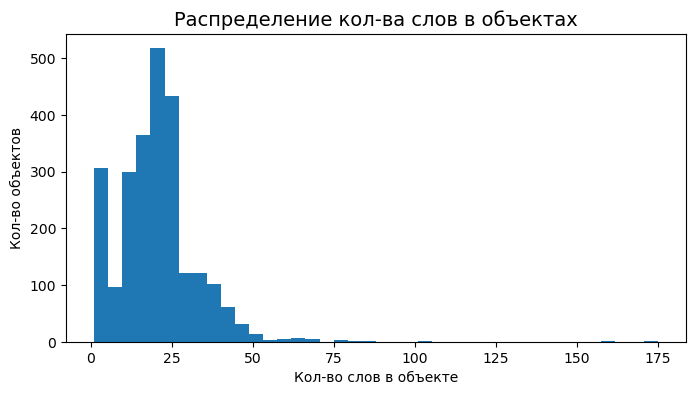

In [50]:
plt.figure(figsize=(8, 4))

plt.title('Распределение кол-ва слов в объектах', fontsize=14)
plt.hist(x='text_count', data=df_plus_cats_cleaned_casino2, bins=40)

plt.xlabel('Кол-во слов в объекте')
plt.ylabel('Кол-во объектов')
plt.show()

In [65]:
# Как в дальнейшем оказалось, результат получается лучше если не удалять объекты
# с большим количеством слов

In [52]:
df_plus_cats_cleaned_casino2.loc[
    df_plus_cats_cleaned_casino2['category_id']== -1, 'name'] = 'Casino'

In [ ]:
# Есть категории, число записей которых меньше 9.
# Чтобы далее равномерно разбить на train/test/val и K_FOLDS=3, нужно их удалить.
df_counts = df_plus_cats_cleaned_casino2['category_id'].value_counts()
df_plus_cats_cleaned_casino2 = df_plus_cats_cleaned_casino2[
    df_plus_cats_cleaned_casino2['category_id'].map(df_counts) > 8]

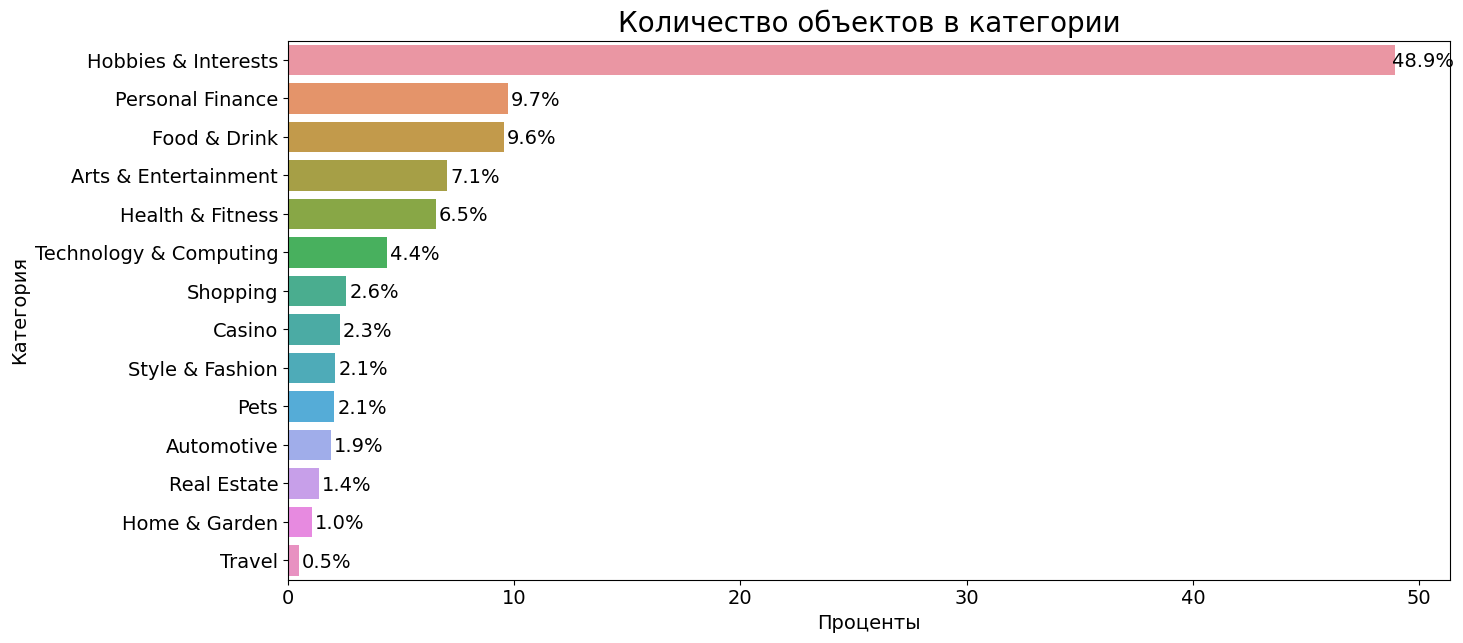

In [64]:
def plot_text(ax):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_width())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_width(), p.get_y() + p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(20, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)
        
# нормирование на размер датасета
norm_target = (df_plus_cats_cleaned_casino2
               .name
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(y='index', x='percent', data=norm_target, orient='h')

plot_text(ax)

plt.title('Количество объектов в категории', fontsize=20)
plt.xlabel('Проценты', fontsize=14)
plt.ylabel('Категория', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [54]:
# Пробовал брать сэмпл с сокращённым количеством объектов в категории
# Hobbies & Interests,
# но это привело к большому переобучению

Создаём числовые признаки

In [57]:

df_text = list(df_plus_cats_cleaned_casino2['text'].values)
for i in range(len(df_text)):
    df_text[i] = " ".join(
        [morph.parse(word)[0].normal_form for word in df_text[i].split()])
    df_text[i] = re.sub(r"[^a-zA-Zа-яА-ЯЁё\s]", "", df_text[i])
    for word in ['google', 'ru', 'app', 'apps', 'com', 'android', 'apple', 'lv']:
        df_text[i] = re.sub(rf"\b{word}\b", "",
                            df_text[i], flags=re.IGNORECASE)

In [58]:
vectorizer = TfidfVectorizer(max_df=0.9,
                            # Оставим только значимые слова,
                            # чтобы сократить количество признаков
                             max_features=9000,
                            #  strip_accents='unicode',
                            #  preprocessor='callable',
                            #  analyzer='char_wb',
                             ngram_range=(1, 1))
df_numbers = vectorizer.fit_transform(df_text).toarray()
df_numbers[:4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1]:
# Наилучшие метрики качества получились именно при таких гиперпараметрах
# Большее уменьшение количества признаков снижает результаты метрик

In [59]:
df_words = vectorizer.get_feature_names_out()
df_words[:4]

array(['abc', 'abenteuern', 'ability', 'ablians'], dtype=object)

In [60]:
numbers_words = pd.DataFrame(df_numbers, columns=df_words)
numbers_words.head()

,abc,abenteuern,ability,ablians,about,abroad,absolviert,absorbing,accepted,access,...,яндексбраузер,яндексмузыка,янина,японский,яркий,ярко,ярмарка,ярославле,ярославль,яф
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# топ средних
numbers_words.mean().sort_values(ascending=False)

play                           0.038705
on                             0.038217
playgooglecom                  0.036945
and                            0.025398
the                            0.020723
                                 ...   
альбумин                       0.000030
кислотавитамин                 0.000030
кислотажелезомедьсодержание    0.000030
гр                             0.000030
накопить                       0.000030
Length: 8807, dtype: float64

In [62]:
numbers_words.to_csv('data\\numbers_words.csv')

In [63]:
df_plus_cats_cleaned_casino2.to_csv('data\df_plus_cats_cleaned_casino2.csv')